# <b>N.Sherone (DST 21023)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

C:\Users\SHERONE\AppData\Local\Temp\ipykernel_12196\864493129.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df=pd.read_csv('amazon_reviews.csv',sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [3]:
df.shape

(4915, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


Removing non-alphanumeric characters, digits, and converting to lowercase

In [5]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

In [6]:
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [7]:
df['reviewText'] = df['reviewText'].str.lower()

Stemming and Lemmatization
Stemming and Lemmatization are techniques used to reduce words to their root forms. In this case, Porter stemming and WordNet lemmatization are applied

In [8]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
nltk.download('wordnet')
df['reviewText'] = df['reviewText'].fillna('')


porter = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()


df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SHERONE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Removing Stopwords and Rare Words
Stopwords are common words that do not carry much meaning (e.g., "the", "is", "and"). Rare words are those with very low frequency in the corpus, which may not contribute much to the analysis.

In [9]:
drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

Tokenization
 is the process of splitting text into smaller parts, such as words or sentences.

In [10]:
import nltk
nltk.download('punkt')
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SHERONE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0                                         [no, issues]
1    [purchas, thi, for, my, device, it, work, a, a...
2    [it, work, a, expected, i, should, have, sprun...
3    [thi, think, ha, work, out, great.had, a, diff...
4    [bought, it, with, retail, packaging, arriv, l...
Name: reviewText, dtype: object

In [11]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

df['reviewText'].head(10)

0                                           no issues.
1    purchas thi for my device, it work a advertise...
2    it work a expected. i should have sprung for t...
3    thi think ha work out great.had a diff. bran 6...
4    bought it with retail packaging, arriv legit, ...
5    it' mini storage. it doesn't do anyth el and i...
6    i have it in my phone and it never skip a beat...
7    it' hard to believ how afford digit ha become....
8    work in a htc rezound. wa run short of space o...
9    in my galaxi s4, super fast card, and am total...
Name: reviewText, dtype: object

In [12]:
tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()

C:\Users\SHERONE\AppData\Local\Temp\ipykernel_12196\853758125.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\SHERONE\AppData\Local\Temp\ipykernel_12196\853758125.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\SHERONE\AppData\Local\Temp\ipykernel_12196\853758125.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
C:\Users\SHERONE\AppData\Local\Temp\ipykernel_12196\853758125.py:1: FutureWarning: v

,words,tf
0,no,1245.0
1,issues.,115.0
2,a,7063.0
3,for,3966.0
4,thi,4373.0


Exclude common stop words like "is," "and," "the," etc., while retaining words like "not," "never," and "no" in your term frequency calculation. Adjust the stop words list as needed for your specific requirements.

In [13]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stop_words.difference_update({'not','never','no'})
def calculate_tf(review):
    words = [word for word in review.split() if word.lower() not in stop_words]
    return pd.Series(words).value_counts()
tf = df["reviewText"].apply(calculate_tf).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
print(tf.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHERONE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     words      tf
0       no  1245.0
1  issues.   115.0
2      thi  4373.0
3  purchas   457.0
4     sinc   221.0


In [14]:
tf.shape

(14045, 2)

In [15]:
tf["words"].nunique()

14045

In [16]:
tf.describe()

,tf
count,14045.000000
mean,10.287362
std,76.964610
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,4373.000000


The baar plot visually represents the most frequent words in the data set. By comparing threshold of 500 occurence

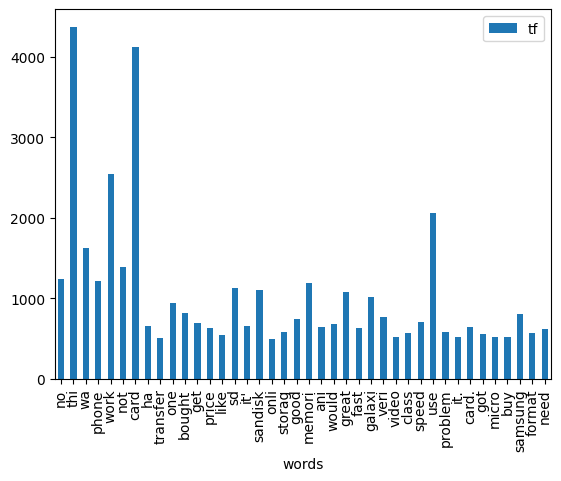

In [17]:
tf[tf["tf"] >500].plot.bar(x="words", y="tf")
plt.show()


Bellow code creates customized word cloud visualization with specific font size,muximum number of words and background color,and then saves the generated word cloun image into file.

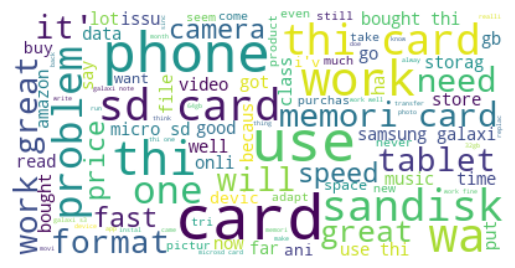

In [18]:
text=" ".join(i for i in df.reviewText)
wordcloud=WordCloud(max_font_size=50,max_words=100,background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud.png")

In [19]:
df.head(5)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",no issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchas thi for my device, it work a advertise...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it work a expected. i should have sprung for t...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",thi think ha work out great.had a diff. bran 6...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought it with retail packaging, arriv legit, ...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [20]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SHERONE\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [21]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",no issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchas thi for my device, it work a advertise...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it work a expected. i should have sprung for t...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",thi think ha work out great.had a diff. bran 6...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought it with retail packaging, arriv legit, ...",5.0,best deal around,1373673600,2013-07-13,513,0,0


certain columns are not contributing to sentiment analysis task or are redundant, I choosed to drop them to simplify the dataset and reduce noise. For example, columns like 'reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime', 'day_diff', 'helpful_yes', 'total_vote' may not be directly relevant to sentiment analysis

In [22]:
df2 = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime', 'day_diff', 'helpful_yes', 'total_vote']
df.drop(columns=df2, inplace=True)

In [23]:
df.head()

,reviewText,overall
0,no issues.,4.0
1,"purchas thi for my device, it work a advertise...",5.0
2,it work a expected. i should have sprung for t...,4.0
3,thi think ha work out great.had a diff. bran 6...,5.0
4,"bought it with retail packaging, arriv legit, ...",5.0


In [24]:
unique_ratings=df['overall'].unique()
print(unique_ratings)

[4. 5. 3. 1. 2.]


In [74]:
def classify_sentiment(rating):
    if rating>=4:
        return 'possitive'
    if rating <= 2:
        return 'negative'
    else:
        return 'neutral'
df['sentiment']=df['overall'].apply(classify_sentiment)
df.head()


,reviewText,overall,sentiment
0,no issues.,4.0,possitive
1,"purchas thi for my device, it work a advertise...",5.0,possitive
2,it work a expected. i should have sprung for t...,4.0,possitive
3,thi think ha work out great.had a diff. bran 6...,5.0,possitive
4,"bought it with retail packaging, arriv legit, ...",5.0,possitive


In [26]:
sentiment_counts=df['sentiment'].value_counts()
sentiment_counts

sentiment
positive    4449
negative     324
neutral      142
Name: count, dtype: int64

In [27]:
from imblearn.over_sampling import SMOTE

it's evident that there is an imbalance in the distribution of sentiment labels in the dataset

Word Embedding with Word2Vec

The first part involves importing the necessary libraries and initializing a Word2Vec model with specific parameters.
The text data is processed to create a list of lists where each sublist contains the tokenized words of a review.
The Word2Vec model is trained on the tokenized sentences to generate word embeddings.

In [28]:
from gensim.models import Word2Vec
processed_texts=df['reviewText'].tolist()
sentences=[text.split() for text in processed_texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word_vocab = word2vec_model.wv.key_to_index.keys()


review_embeddings = []
for sentence in sentences:
    embeddings = [word2vec_model.wv[word] for word in sentence if word in word_vocab]
    if embeddings:
        review_embeddings.append(np.mean(embeddings, axis=0))
    else:
        review_embeddings.append(np.zeros(word2vec_model.vector_size))


SMOTE Oversampling
SMOTE is applied to balance the dataset by oversampling the minority class (presumably 'sentiment' in this context).
SMOTE generates synthetic samples to balance class distribution by interpolating between minority class instances.
X_resampled contains the resampled embeddings, and y_resampled contains the corresponding sentiment labels after applying SMOTE.

In [29]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(review_embeddings, df['sentiment'])

In [30]:
print("Before SMOTE:")
print(df['sentiment'].value_counts())

Before SMOTE:
sentiment
positive    4449
negative     324
neutral      142
Name: count, dtype: int64


In [31]:
print("After SMOTE:")
print(y_resampled.value_counts())

After SMOTE:
sentiment
positive    4449
neutral     4449
negative    4449
Name: count, dtype: int64


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Min-Max scaling, also known as normalization, is a common technique used in machine learning to scale features to a range between a specified minimum and maximum value. The purpose of scaling features is to ensure that all features contribute equally to the analysis, particularly in algorithms sensitive to feature scales, such as distance-based algorithms.

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [34]:
from sklearn.naive_bayes import MultinomialNB


nb_model = MultinomialNB()
nb_model.fit(X_train_scaled, y_train)


nb_accuracy = nb_model.score(X_test_scaled, y_test)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.5378277153558052


In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

rf_accuracy = rf_model.score(X_test_scaled, y_test)
print("Random Forest Accuracy:", rf_accuracy)

Random Forest Accuracy: 0.9677902621722847


In [36]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

knn_accuracy = knn_model.score(X_test_scaled, y_test)
print("KNN Accuracy:", knn_accuracy)

KNN Accuracy: 0.8662921348314607


In [37]:

from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)
logistic_accuracy = logistic_model.score(X_test_scaled, y_test)
print("Loistic regression Accuracy:", logistic_accuracy)

Loistic regression Accuracy: 0.652434456928839


c:\Users\SHERONE\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


param_grid = {
    'n_estimators': [50,100,200],
 
}


rf_model = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=6, n_jobs=-1, verbose=2)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)


Fitting 6 folds for each of 3 candidates, totalling 18 fits
Best Parameters: {'n_estimators': 200}
Test Accuracy: 0.9711610486891386


In [93]:
predictions = best_model.predict(X_test_scaled)

index_sequence = range(len(predictions))
for index, prediction in zip(index_sequence, predictions):
    print(f"{index}\t{prediction}")

0	negative
1	negative
2	negative
3	negative
4	positive
5	neutral
6	neutral
7	neutral
8	negative
9	positive
10	positive
11	positive
12	positive
13	positive
14	positive
15	positive
16	positive
17	positive
18	neutral
19	negative
20	negative
21	negative
22	neutral
23	neutral
24	negative
25	neutral
26	negative
27	neutral
28	positive
29	neutral
30	neutral
31	positive
32	negative
33	positive
34	negative
35	negative
36	neutral
37	neutral
38	positive
39	negative
40	negative
41	negative
42	negative
43	neutral
44	negative
45	negative
46	negative
47	neutral
48	negative
49	neutral
50	negative
51	negative
52	positive
53	negative
54	negative
55	negative
56	neutral
57	positive
58	positive
59	neutral
60	negative
61	neutral
62	negative
63	neutral
64	neutral
65	neutral
66	negative
67	positive
68	positive
69	negative
70	neutral
71	negative
72	positive
73	positive
74	neutral
75	positive
76	neutral
77	negative
78	negative
79	positive
80	positive
81	neutral
82	positive
83	neutral
84	positive
85	positive
86	p

In [84]:
y_test

5723    negative
7586    negative
5958    negative
7945    negative
4237    positive
          ...   
5632    negative
2380    positive
7660    negative
2340    positive
265     positive
Name: sentiment, Length: 2670, dtype: object

In [39]:
importances = best_model.feature_importances_
top_features_indices = importances.argsort()[-10:][::-1]  

In [40]:
feature_names = list(word2vec_model.wv.key_to_index.keys())
top_features = [feature_names[i] for i in top_features_indices]

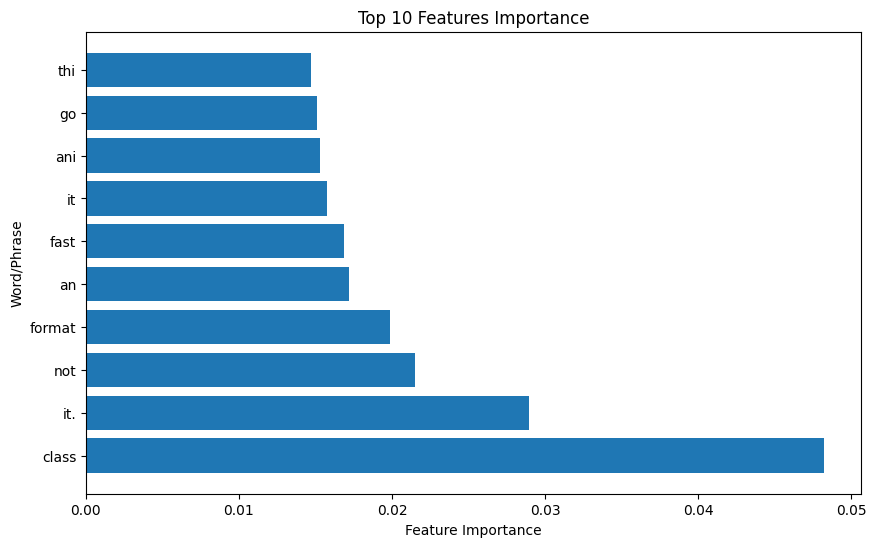

In [41]:

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[top_features_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Word/Phrase')
plt.title('Top 10 Features Importance')
plt.show()

In [42]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test_scaled)

class_report = classification_report(y_test, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.99      0.97       908
     neutral       0.99      0.99      0.99       857
    positive       0.99      0.93      0.96       905

    accuracy                           0.97      2670
   macro avg       0.97      0.97      0.97      2670
weighted avg       0.97      0.97      0.97      2670



In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[900,   1,   7],
       [  4, 850,   3],
       [ 51,  11, 843]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

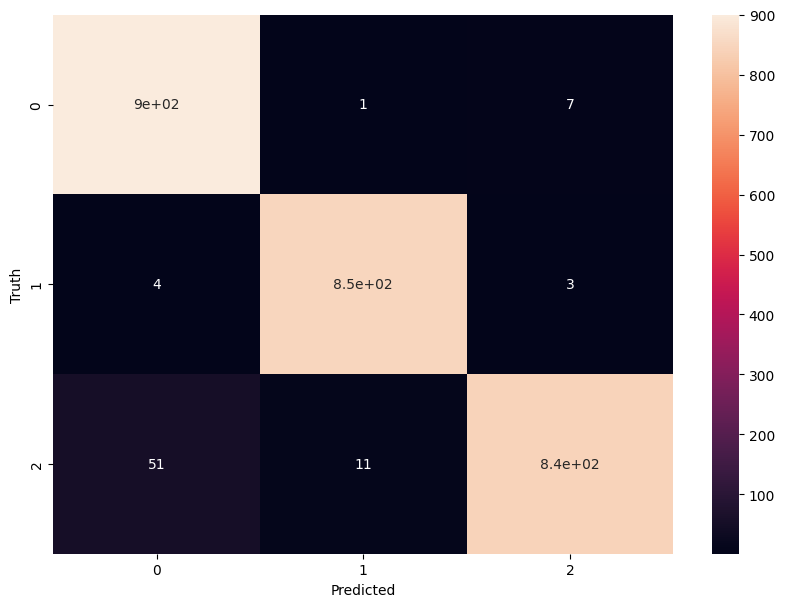

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

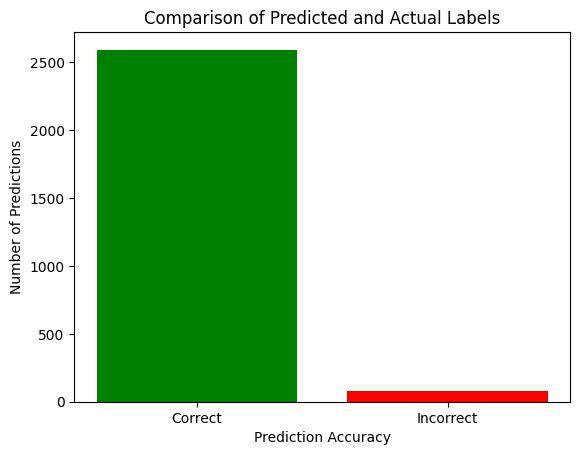

In [45]:
import matplotlib.pyplot as plt

correct_predictions = (y_test == y_pred).sum()
incorrect_predictions = len(y_test) - correct_predictions

plt.bar(['Correct', 'Incorrect'], [correct_predictions, incorrect_predictions], color=['green', 'red'])
plt.xlabel('Prediction Accuracy')
plt.ylabel('Number of Predictions')
plt.title('Comparison of Predicted and Actual Labels')
plt.show()